Basic data cleaning

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')

#data understanding
df.info()#number and name of columns

#scrub for irrelevant data
df.drop('CustomerID', axis=1, inplace=True)

#scrub for duplicate data
print("Duplicated rows:",df.duplicated().sum())# entirely duplicated rows
df.drop_duplicates(inplace = True)

# dropping rows with missing data
df.dropna(inplace=True)

# Handling Outliers. Column of interest(Annual Income (k$))
# Drawing the box plot for the treated column
#sns.boxplot(y=df['Annual Income (k$)'])

# To save the plot
#plt.savefig('treated_annual_income_boxplot_2.png')

col = 'Annual Income (k$)'

# finding Q1, Q3, and IQR(interquartile range)
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

# outlier bounds : fences outside of which data points are seen as outliers
lower_bound = Q1 - 1.5 * IQR  # Calculated as -13.25
upper_bound = Q3 + 1.5 * IQR  # Calculated as 132.75

# Capping (Winsorizing): replacing the values above the upper bound with the upper bound and also those below the lower bound with the lower bound
df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# encoding categorical variables(gender(male, female))
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
Duplicated rows: 0


EDA and 3 insights from the cleaned data set
Insights include:
1. Female spend more on average than men
2. Five key customer segments(From the scatter plot of Annual Income vs Spending Score):
       1. low income low spending
       2. high income low spending
       3. low income high spending
       4. high income high spending
       5. mid-income mid-spending(centre)
3. Age and spending distribution
     where: The largest customer group is the young-to-middle-aged demographic, the income is concentrated in the middle range and this suggests a majority of customers are mid-range earners and the spending scores are relatively uniformly distributed between 40 and 60, with two smaller spikes near the extreme ends (20 and 80). This uniform distribution hints at distinct customer segments based on spending habits.


Gender Group Statistics (Mean)
|        |     Age |   Annual Income (k$) |   Spending Score (1-100) |
|:-------|--------:|---------------------:|-------------------------:|
| Female | 38.0982 |              59.25   |                  51.5268 |
| Male   | 39.8068 |              62.1307 |                  48.5114 |


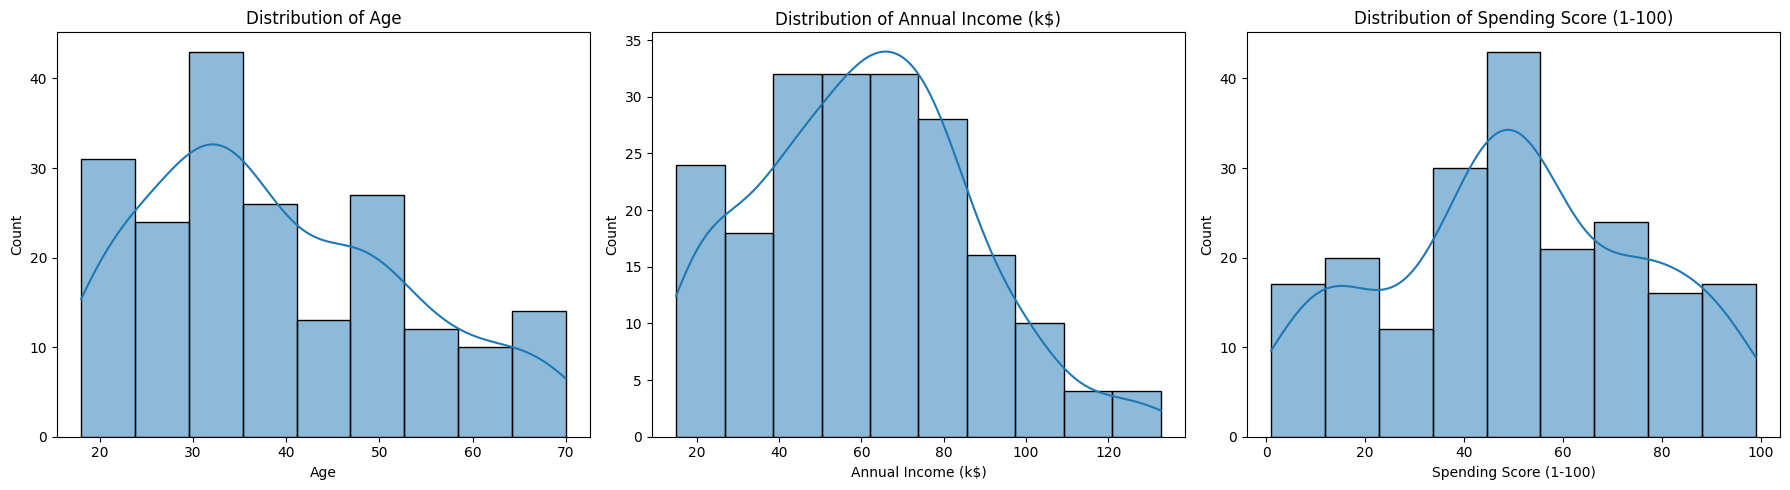

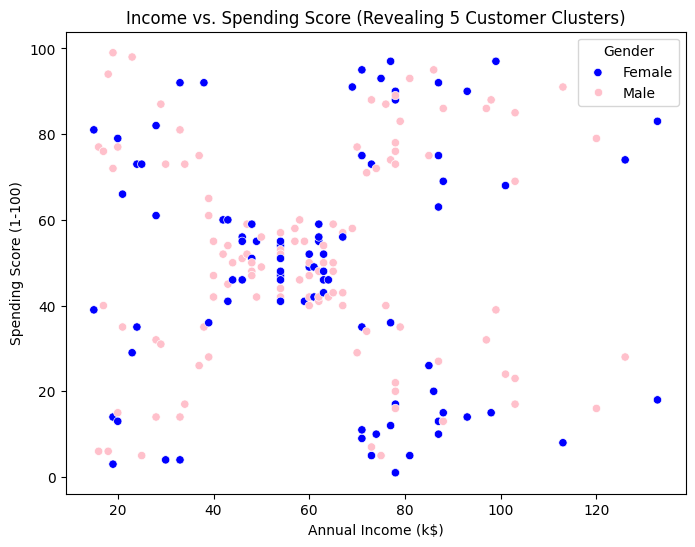

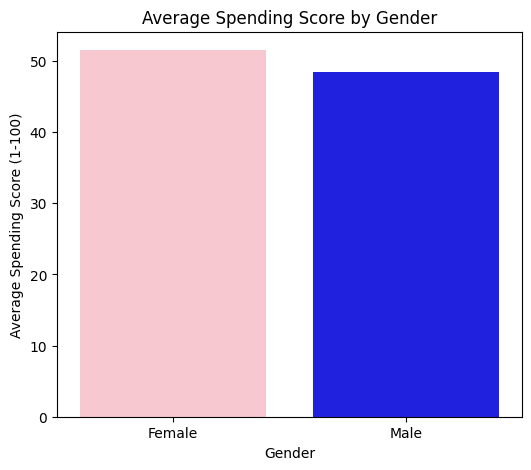

In [18]:
#  INSIGHT 1: Distribution of Key Variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for i, col_name in enumerate(numerical_cols):
    sns.histplot(df[col_name], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col_name}')

plt.tight_layout()
plt.savefig('distribution_plots.png')


#  INSIGHT 2: Segmentation of Income vs. Spending
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df,hue='Gender_Male', palette={0: 'pink', 1: 'blue'}
)
plt.title('Income vs. Spending Score (Revealing 5 Customer Clusters)')
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.savefig('income_spending_scatter.png')


#  INSIGHT 3: Gender Comparison (Average Spending)
gender_col = 'Gender_Male'
gender_stats = df.groupby(gender_col)[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
gender_stats.index = ['Female', 'Male']

print("\nGender Group Statistics (Mean)")
print(gender_stats.to_markdown())

# The difference in Average Spending Score
plt.figure(figsize=(6, 5))
gender_stats_plot = gender_stats.reset_index()
sns.barplot(x='index', y='Spending Score (1-100)', data=gender_stats_plot,hue='index', palette={'Female': 'pink', 'Male': 'blue'}, legend=False)
plt.title('Average Spending Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Spending Score (1-100)')
plt.savefig('avg_spending_by_gender.png')

# Ensuring all plots are displayed
plt.show()

Using k-means algorithm to create groups of customers

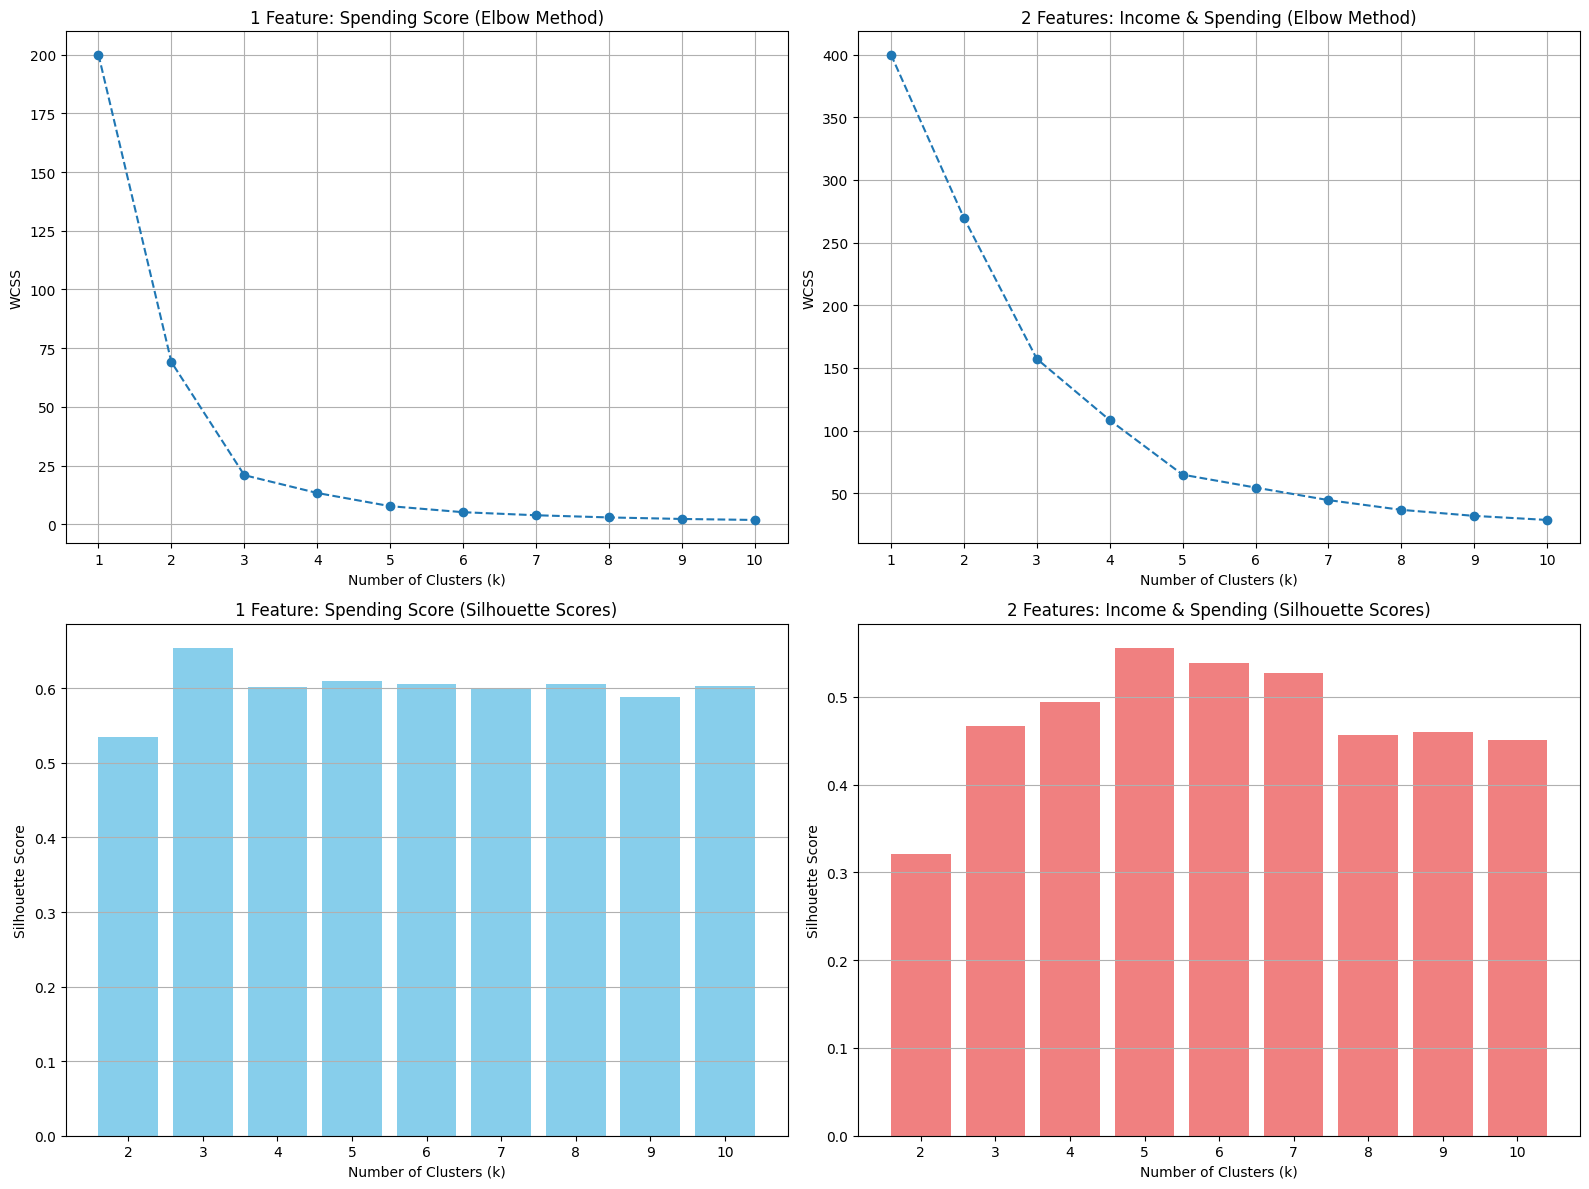

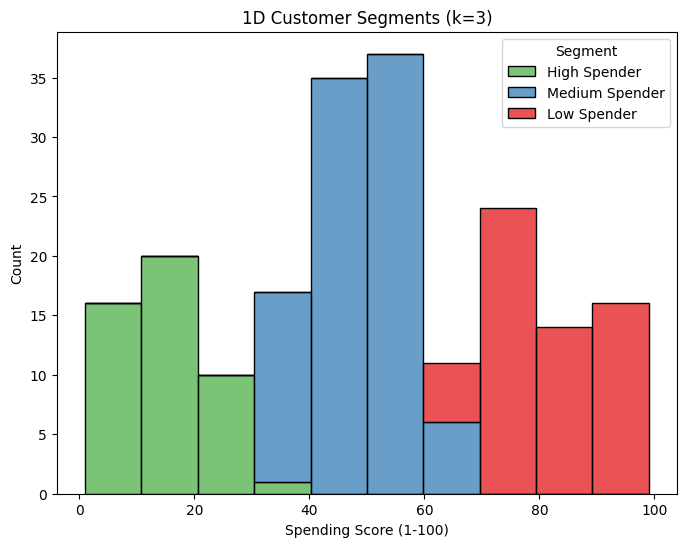

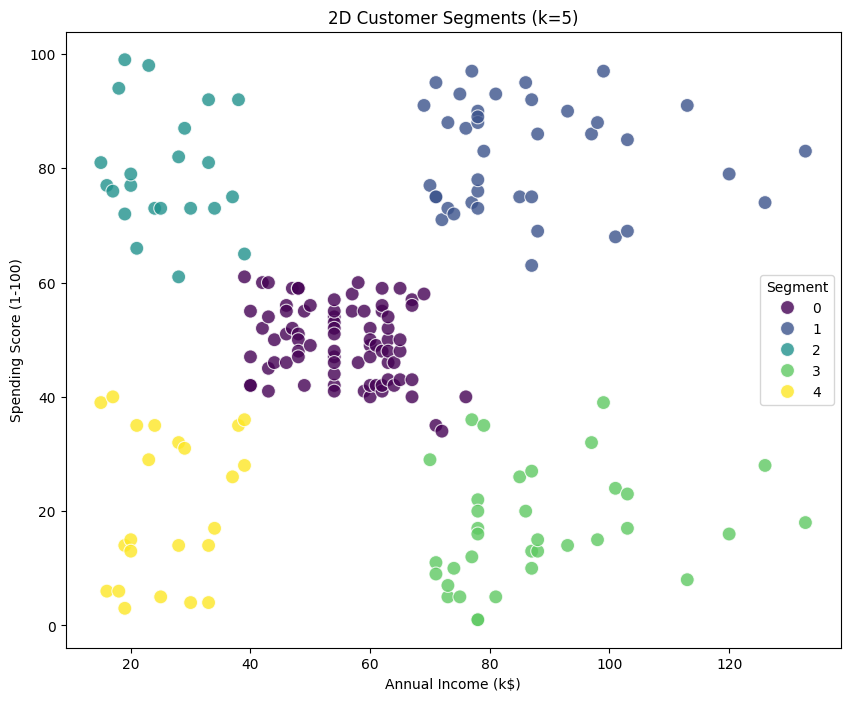

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# --- Define Feature Sets ---
# 1D Feature: Spending Score (X1)
X1 = df[['Spending Score (1-100)']]
# 2D Features: Annual Income & Spending Score (X2)
X2 = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Scale the data for K-Means
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)


# ==============================================================================
# 2. OPTIMAL CLUSTER VERIFICATION (Elbow & Silhouette)
# ==============================================================================

wcss_1d, silhouette_1d = [], {}
wcss_2d, silhouette_2d = [], {}
k_range = range(1, 11)

for k in k_range:
    # 1D Metrics
    kmeans1 = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans1.fit(X1_scaled)
    wcss_1d.append(kmeans1.inertia_)

    # 2D Metrics
    kmeans2 = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans2.fit(X2_scaled)
    wcss_2d.append(kmeans2.inertia_)

# Calculate Silhouette (k >= 2)
for k in range(2, 11):
    kmeans1 = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels1 = kmeans1.fit_predict(X1_scaled)
    silhouette_1d[k] = silhouette_score(X1_scaled, labels1)

    kmeans2 = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels2 = kmeans2.fit_predict(X2_scaled)
    silhouette_2d[k] = silhouette_score(X2_scaled, labels2)

# --- Plot Verification Metrics ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1D Elbow
axes[0, 0].plot(k_range, wcss_1d, marker='o', linestyle='--')
axes[0, 0].set_title('1 Feature: Spending Score (Elbow Method)')
axes[0, 0].set_xlabel('Number of Clusters (k)'); axes[0, 0].set_ylabel('WCSS'); axes[0, 0].set_xticks(k_range); axes[0, 0].grid(True)

# 2D Elbow
axes[0, 1].plot(k_range, wcss_2d, marker='o', linestyle='--')
axes[0, 1].set_title('2 Features: Income & Spending (Elbow Method)')
axes[0, 1].set_xlabel('Number of Clusters (k)'); axes[0, 1].set_ylabel('WCSS'); axes[0, 1].set_xticks(k_range); axes[0, 1].grid(True)

# 1D Silhouette
k_values = list(silhouette_1d.keys())
s_scores = list(silhouette_1d.values())
axes[1, 0].bar(k_values, s_scores, color='skyblue')
axes[1, 0].set_title('1 Feature: Spending Score (Silhouette Scores)')
axes[1, 0].set_xlabel('Number of Clusters (k)'); axes[1, 0].set_ylabel('Silhouette Score'); axes[1, 0].set_xticks(k_values); axes[1, 0].grid(axis='y')

# 2D Silhouette
k_values = list(silhouette_2d.keys())
s_scores = list(silhouette_2d.values())
axes[1, 1].bar(k_values, s_scores, color='lightcoral')
axes[1, 1].set_title('2 Features: Income & Spending (Silhouette Scores)')
axes[1, 1].set_xlabel('Number of Clusters (k)'); axes[1, 1].set_ylabel('Silhouette Score'); axes[1, 1].set_xticks(k_values); axes[1, 1].grid(axis='y')

plt.tight_layout()
plt.show() # Display the verification metrics


# ==============================================================================
# 3. K-MEANS CLUSTERING (k=3 for 1D, k=5 for 2D)
# ==============================================================================

# Final optimal k values based on verification
optimal_k_1d = 3
optimal_k_2d = 5

# --- 1D K-Means ---
kmeans_1d = KMeans(n_clusters=optimal_k_1d, init='k-means++', random_state=42, n_init=10)
df['Segment_1D'] = kmeans_1d.fit_predict(X1_scaled)

# --- 2D K-Means ---
kmeans_2d = KMeans(n_clusters=optimal_k_2d, init='k-means++', random_state=42, n_init=10)
df['Segment_2D'] = kmeans_2d.fit_predict(X2_scaled)


# --- Plot 1D Segments ---
plt.figure(figsize=(8, 6))
# Plots the distribution, separated by the assigned cluster
sns.histplot(data=df, x='Spending Score (1-100)', hue='Segment_1D', palette='Set1', multiple='stack', bins=10)
plt.title(f'1D Customer Segments (k={optimal_k_1d})')
plt.xlabel('Spending Score (1-100)')
plt.legend(title='Segment', labels=['High Spender', 'Medium Spender', 'Low Spender'])
plt.show()


# --- Plot 2D Segments ---
plt.figure(figsize=(10, 8))
# Plots the actionable 5-segment pattern
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Segment_2D',
    data=df,
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title(f'2D Customer Segments (k={optimal_k_2d})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Segment')
plt.show()

comments on the distribution structure:

1. 1-Feature Clustering: Spending Score (k=3)

The clustering using only the Spending Score (1-100) resulted in three clear, non-overlapping groups, as verified by the Silhouette Score. The histogram shows how these three segments are distributed across the spending axis.

Distribution :

Axis of Separation: The groups are separated entirely along the Spending Score dimension.
Low Spenders (Segment 2):This cluster is highly concentrated at the lower end of the score (mean score = 14.6), containing customers who spend very little at the mall.
High Spenders (Segment 0): This cluster is concentrated at the upper end of the score (mean score = 81.8), representing the most active shoppers.
Medium Spenders (Segment 1): This cluster forms a large, centralized, near-normal distribution around the average spending score (mean score = 48.2).
Utility: This segmentation is useful for operational decisions (e.g., allocating customer service resources or measuring the effectiveness of general promotions) but provides limited insight into why the customers spend the way they do (i.e., we don't know their income).


2. 2-Feature Clustering: Annual Income and Spending Score (k=5)

The clustering using Annual Income (k$) and Spending Score (1-100) resulted in five distinct groups, which is considered the optimal and most actionable segmentation for this dataset.



Distribution:

Axis of Separation: The clusters are distributed in two-dimensional space, leading to far greater separation and interpretability.
Distribution Type: The groups are now defined by quadrants and a center, clearly revealing customer profiles:
    High-Income/High-Spending (Segment 1): Tightly clustered in the top-right corner.
    Low-Income/High-Spending (Segment 2): Clustered in the top-left corner.
    High-Income/Low-Spending (Segment 3): Clustered in the bottom-right corner.
    Low-Income/Low-Spending (Segment 4): Clustered in the bottom-left corner.
    Mid-Range (Segment 0): Clustered near the center of the plot.
    Utility: This distribution is highly valuable for strategic marketing and business planning because it defines both the willingness to spend (Y-axis) and the capacity to spend (X-axis).

Comparison of Clustering Models

1. 1-Feature Clustering (Spending Score)

When clustering was performed using only 1 suitable feature (Spending Score), the optimal number of groups identified was k=3. The resulting segments exhibit a One-Dimensional Stacked Distribution. This means the groups are simply lined up along the single spending axis, representing a basic volume split into Low, Medium, and High Spenders. Consequently, the Actionability of this model is Limited, as it only provides simple, broad divisions of the customer base.

2. 2-Features Clustering (Income & Spending)

In contrast, clustering based on 2 suitable features (Annual Income and Spending Score) revealed an optimal number of groups at k=5. The clusters exhibit a Two-Dimensional Quadrants Distribution, which is significantly more informative. In this, the groups are defined by the intersection of both behavior (spending) and capacity (income). This high-resolution profiling allows for highly targeted and profitable marketing strategies, making the model's Actionability High.


Different ways the mall management can interact with their customers

Based on the five groups defined by the Annual Income and Spending Score :

1. Top Targets

This segment is defined by both high income and high spending. The strategy here is primarily focused on retention and loyalty. Management should engage them with exclusivity and premium rewards. This includes inviting them to private pre-sale events, offering the highest tier of loyalty programs, providing personalized concierge services, and giving them early access to new luxury brand arrivals.

2. High-Income Frugals

These customers possess high income but low spending and represent a prime conversion opportunity. Engagement should emphasize the value proposition and quality assurance. Mall management should interact with them through personalized communications that focus on the long-term benefits and investment value of high-end products, rather than relying on discounts.

3. Budget Spenders (Impulse)

Characterized by low income but high spending, these customers are often young and respond to immediate incentives. The strategy should focus on gamification and increasing visit frequency. Management should engage them heavily on social media platforms, use interactive campaigns, and offer frequent small flash sales or time-sensitive mobile promotions (e.g., app-based coupons).

4. Mid-Range/Average

This large group falls near the center of the distribution with moderate income and average spending. The interaction should focus on maintenance and subtle upselling. Management should include them in standard, tiered loyalty programs and send general promotional newsletters. Surveys can also be used to gather feedback and nudge them toward higher spending categories.

5. Low-Value/Low-Budget

These customers have low income and low spending and represent the lowest value segment. Engagement should be minimal and efficient. Interaction should be limited to broad, impersonal communications, such as in-store flyers, focusing only on essential services, clearance events, and budget-friendly offerings to manage them efficiently.